# World Data League 2022

### 1 -[Introduction](#first-bullet)

###  2 -[Exploratory Data Analysis (EDA)](#second-bullet)

###  3 -[Forecasting Model](#third-bullet)

###  4 -[Conclusion](#fourth-bullet)

###  5 -[References](#fifth-bullet)

## 🎯 Challenge
Predicting the flow of people for public transportation improvements

## Team: 
## 👥 Authors
* Ana Luiza Kaori Akiyama
* Guilherme Caixeta
* Luiz Gustavo Moniz

## Environment Setup (Google Colab)

In [2]:
!apt-get install megatools
!megadl 'https://mega.nz/#!K4sWgZwb!r590QXRauNnYIAie10KrOoK1oMEzpOLvMDL9Xn9u9TY'
!unzip 'data.zip'
!pip install -r data/requirements.txt

zsh:1: command not found: megadl
unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


## 💻 Development

##  1 - <span style="color:blue">Introduction</span>  <a class="anchor" id="first-bullet"></a>

The city of Porto has one of the worst traffic situations in the world, ranking 158th in the 2021 world Traffic Index¹. This situation has a number of reasons, like the geography of the city, the difficulty of urban planning, the lack of a mobility plan for the Metropolitan Area of Porto and a public transportation system that doesn't meet the population demands². 

##  2 - <span style="color:blue">Exploratory Data Analysis (EDA)</span>  <a class="anchor" id="second-bullet"></a>

In this notebook, we are going to explore the dataset provided for this challenge, which is divided into 3 folders. The first one, "TIPS", contains how many validations (per hour) occur in each bus or subway stop. The GTFS dataset provides geospatial data that is important to understand spatial patterns that occur on Porto. The last dataset contains inter municipality data around Portugal.

In [130]:
import pickle
import warnings
import geopandas as gpd
import gtfs_functions as gtfs
import holidays
import holoviews as hv
import hvplot.pandas
import matplotlib
import matplotlib.dates as md
import numpy as np
import pandas as pd
import plotly.express as px
import pytorch_lightning as pl
import seaborn as sns
import simplejson as json
import unicodedata

from shapely import wkt
from itertools import islice
from typing import Any, Callable, Dict, List, Tuple
from gluonts.dataset.common import FileDataset, ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.util import to_pandas
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import backtest_metrics, make_evaluation_predictions
from gluonts.model.seasonal_naive import SeasonalNaivePredictor
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.torch.modules.distribution_output import NegativeBinomialOutput
from IPython.display import display_html
from matplotlib import pyplot as plt
from shapely.geometry import Polygon
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm.autonotebook import tqdm

renderer = hv.renderer("bokeh")
warnings.filterwarnings("ignore")

Firstly, let's analyze the data of all types of Porto transport (bus, metro, train). For this analysis, we will use the data from the TIP Z2Z.

In [2]:
df_overview = pd.read_csv('data/treated_tip_z2z.csv', parse_dates=['date'])

##### Missing Data

We can notice that the column `exit_zone` and `entry_zone` has some missing values.

In [3]:
df_overview.isnull().sum()

year               0
month              0
day                0
hour               0
operator           0
entry_zone     12113
exit_zone      33277
validations        0
date               0
dtype: int64

In [4]:
missing_data = df_overview[df_overview['exit_zone'].isnull()]
missing_percentage = (len(missing_data) / len(df_overview)) * 100
print(f'Exit zone missing data percentage: {missing_percentage}%')

Exit zone missing data percentage: 0.9851101155181264%


In [5]:
empty_data = df_overview[df_overview['entry_zone'].isnull()]
empty_percentage = (len(empty_data) / len(df_overview)) * 100
print(f'Entry zone missing data percentage:: {empty_percentage}%')

Entry zone missing data percentage:: 0.358585173821891%


The Missing data percentage and empty data percentage is very low, so we're going to drop the missing values.

In [6]:
df_overview.dropna(inplace=True)

##### Outliers

To better see the outliers, let's group the dataset by day and by Entry Zone and aggregate the data summing the validations.

In [7]:
df_validations_per_day_and_entry = df_overview.groupby(['month', 'day', 'entry_zone']).aggregate({ 'validations': sum }).reset_index()
df_validations_per_day_and_entry = df_validations_per_day_and_entry.sort_values('validations', ascending=False)
df_validations_per_day_and_exit = df_overview.groupby(['month', 'day', 'exit_zone']).aggregate({ 'validations': sum }).reset_index()
df_validations_per_day_and_exit = df_validations_per_day_and_exit.sort_values('validations', ascending=False)

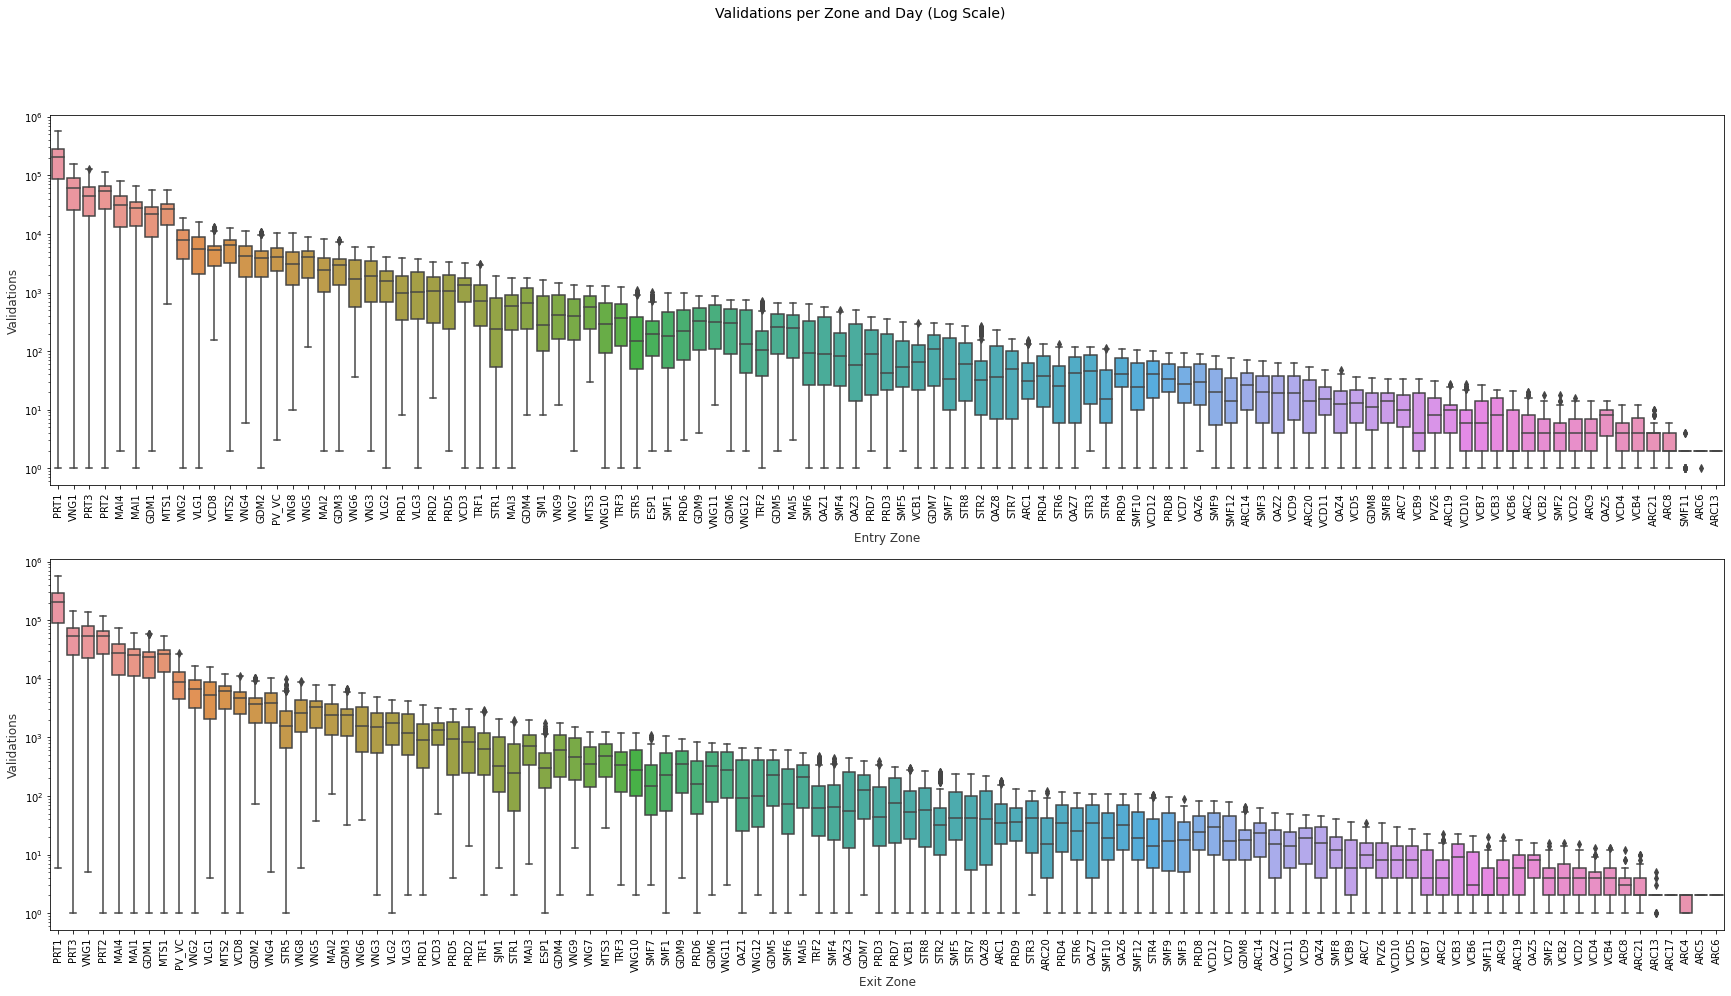

In [8]:
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(30, 15))
f.suptitle(f'Validations per Zone and Day (Log Scale)', fontsize=14)

sns.boxplot(x='entry_zone', y='validations', data=df_validations_per_day_and_entry, ax=axs[0])
axs[0].set_xlabel('Entry Zone',size = 12,alpha=0.8)
axs[0].set_ylabel('Validations',size = 12,alpha=0.8)
axs[0].set_yscale('log')
axs[0].tick_params(axis='x', rotation=90)

sns.boxplot(x='exit_zone', y='validations', data=df_validations_per_day_and_exit, ax=axs[1])
axs[1].set_xlabel('Exit Zone',size = 12,alpha=0.8)
axs[1].set_ylabel('Validations',size = 12,alpha=0.8)
axs[1].set_yscale('log')
axs[1].tick_params(axis='x', rotation=90)

plt.show()

In the above boxplots, we can notice that there aren't many outliers. The few that appear are upper outliers, therefore we will not treat these outliers.

#### Movement through geographic space, from an origin (O) to a destination (D). 

It is possible to realize the Porto metropolitan areas represented on zones PRT1, PRT2, PRT3 and VNG1 on the center of the matrix. This small cluster contains the highest flow of people.

In [9]:
od_map = df_overview.groupby(['entry_zone','exit_zone'])['validations'].sum().dropna().unstack()
s = od_map.hvplot.heatmap(title='Origen-Destination Matrix (2020) - Consolidated Total',width=1600, height=1200)
s.opts(xrotation=90)
html = renderer.html(s)
display_html(html, raw=True)

<!DOCTYPE html>
 
 
 
 
 
 Bokeh Application

#### Visualizing Porto Zones

Let’s visualize where each zone is located in Porto. 

In [10]:
with open ('map_zones', 'rb') as fp:
    ZoneData = pickle.load(fp)

In [11]:
data = pd.DataFrame(columns = ['code', 'geometry'])

for i in range(len(ZoneData)):
    lat_point_list = pd.DataFrame(ZoneData[i]['points']).lat.tolist()
    lon_point_list = pd.DataFrame(ZoneData[i]['points']).lng.tolist()

    polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
    code = ZoneData[i]['code']
    
    ix = pd.DataFrame({'code': code, 'geometry': [polygon_geom]})
    data = data.append(ix)

First let's get the centroid of each zone

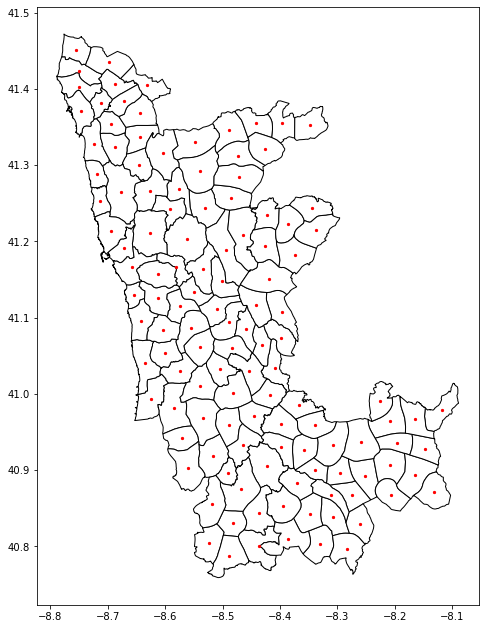

In [12]:
crs = {'init': 'epsg:4326'}
geoFlowDf = gpd.GeoDataFrame(data,geometry = data.geometry, crs=crs)
geoFlowDf['group_zone'] = geoFlowDf['code'].astype(str).str[:2]
points = geoFlowDf.copy()
points['geometry'] = points.to_crs('+proj=cea').centroid.to_crs(points.crs)
points['lon'] = points['geometry'].x
points['lat'] = points['geometry'].y
base = geoFlowDf.plot(color='white', edgecolor='black',figsize=(25,11))

points.plot( ax=base, marker='o', color='red', markersize=5, figsize=(25,11));

Now let's create a map where the zones will be grouped in a higher hierarchy (first two letters of the zone) and combine it with centroid points. 

ps: It is possible to check the entire zone name by hover the mouse over the region

In [13]:
points['t'] = 0.5
s = (geoFlowDf.hvplot(geo=True, tiles='OSM', hover_cols=["code"], alpha=0.5, width=700, height=700, color='group_zone') *
points.hvplot( title='Porto Transportation Zones', size=8, geo=True, width=700, height=700))

html = renderer.html(s)
display_html(html, raw=True)

<!DOCTYPE html>
 
 
 
 
 
 Bokeh Application

##### Operators with the highest flow of people

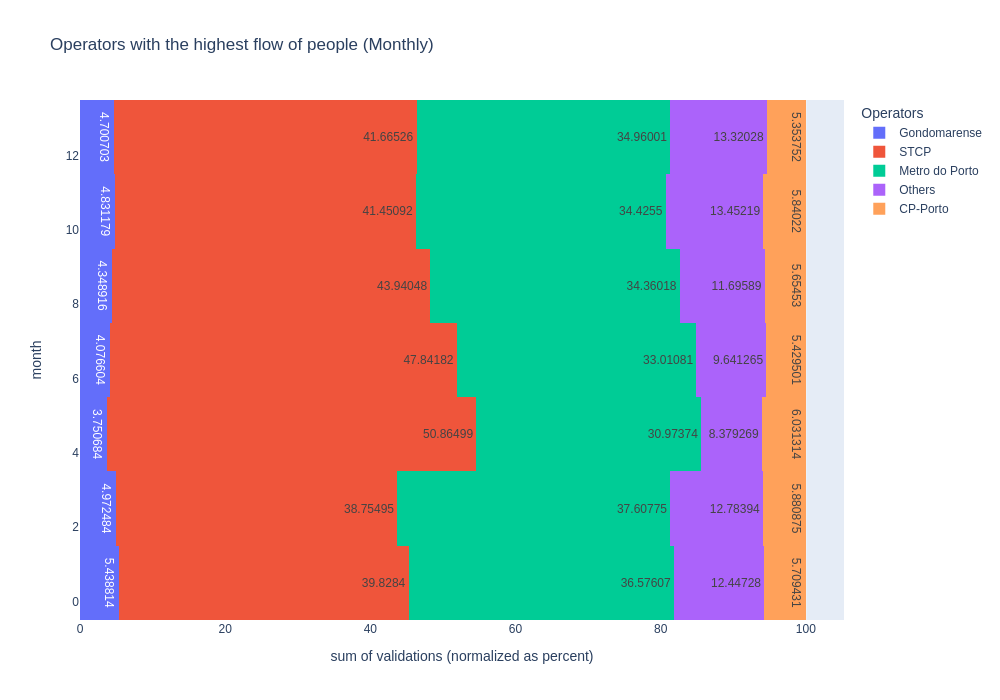

In [19]:
df_overview['Operators'] = np.where(df_overview['operator'].isin(['CP-Porto', 'STCP', 'Metro do Porto', 'Gondomarense']), df_overview['operator'], 'Others' )

fig = px.histogram(df_overview.groupby(['Operators', 'month'])['validations'].sum().sort_values().reset_index(), 
             y='month', 
             x='validations', 
             orientation='h',
             title='Operators with the highest flow of people (Monthly) ', 
             barnorm = "percent",
             text_auto= True,
             color='Operators', 
             height=700)
fig.show("png", width=1000)

In [11]:
df_validations_per_operator = df_overview.groupby(['operator']).aggregate({ 'validations': sum }).reset_index()
df_validations_per_operator = df_validations_per_operator.sort_values(['validations'], ascending=[False])  # validations descending order 
df_validations_per_operator['validations(%)'] = df_validations_per_operator['validations'].apply(lambda x: x / df_validations_per_operator['validations'].sum() * 100).round(2)
df_validations_per_operator = df_validations_per_operator[df_validations_per_operator['validations(%)'] > 1] # remove rows that percentage is below one

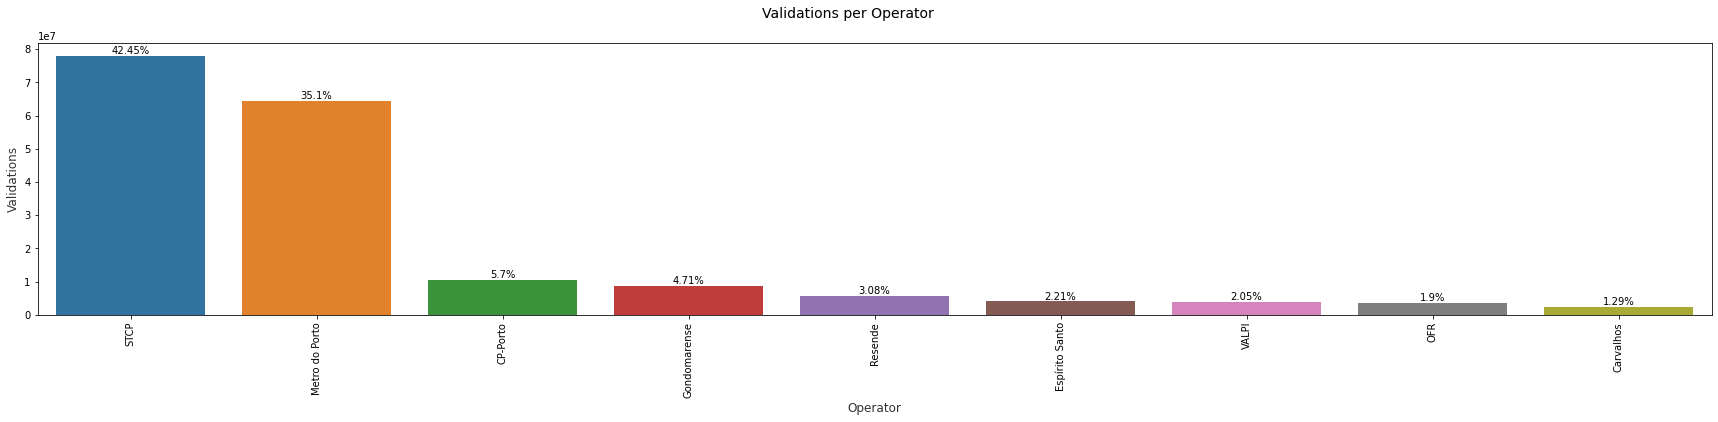

In [12]:
f, ax1 = plt.subplots(1, 1, figsize=(30, 5))
f.suptitle(f'Validations per Operator', fontsize=14)

ax1 = sns.barplot(x='operator', y='validations', data=df_validations_per_operator) 
ax1.set_xlabel('Operator',size = 12,alpha=0.8)
ax1.set_ylabel('Validations',size = 12,alpha=0.8)

for rect, label in zip(ax1.patches, df_validations_per_operator['validations(%)']):
    label = str(label) + '%'
    height = rect.get_height()
    ax1.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

plt.xticks(rotation=90)
plt.show()

More than 70% of the flow focuses on two operators:
- STCP
- Metro do Porto

Some information about the subway and bus in Porto:

According to data from a [survey](https://www.deco.proteste.pt/familia-consumo/orcamento-familiar/noticias/transportes-publicos-ineficazes-em-6-cidades) on mobility in Porto, the timetable, frequency and punctuality (which reach satisfaction levels of 9, out of a maximum of 10) of the subway (**Metro do Porto**) are highly appreciated in Porto. Porto users also show a clear satisfaction with comfort and safety when it comes to accidents.

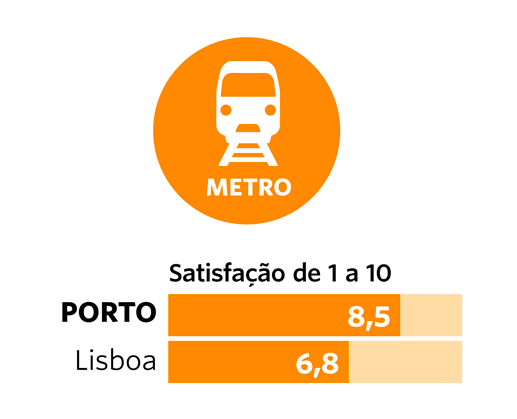

The picture above shows the satisfaction level of the subway, that received 8,5 of 10.

On the opposite of the subway, the bus (**STCP**) received 6 of 10 on satisfaction level.

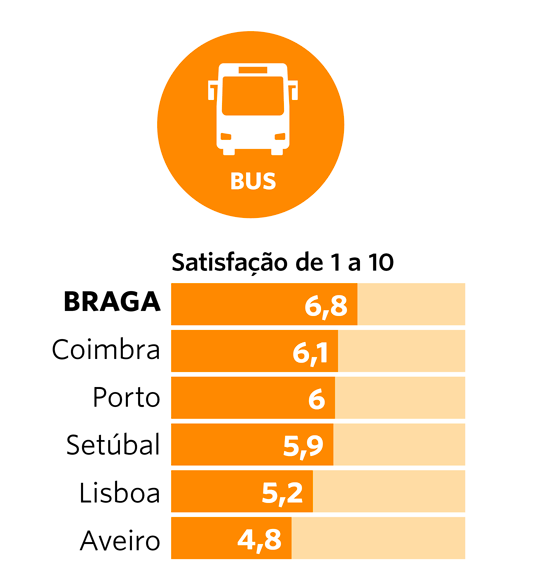

Based on the information above, we can notice that the bus has the largest flow of people and that the level of user satisfaction is lower. So we will focus our research especially on public transportation by bus.

For that, let's use another dataset:

In [13]:
df_bus = pd.read_csv('data/treated_tip_bus.csv', parse_dates=['date']).drop(columns=['Unnamed: 10'])

Before anything else, let's see the most relevant operators.

There some string in the validation column, so we will drop the strings and transform the column to int type.

In [14]:
df_bus = df_bus[~df_bus['validations'].isin(['SMF11     ', 'PRT1      '])]
df_bus['validations'] = df_bus['validations'].astype(int)

In [15]:
df_operator = df_bus.groupby(['operator']).agg({ 'validations': sum }).reset_index()
df_operator['%'] = (100 * df_operator['validations'] / df_operator['validations'].sum()).round()
df_operator.sort_values(by='%', ascending=False, inplace=True)

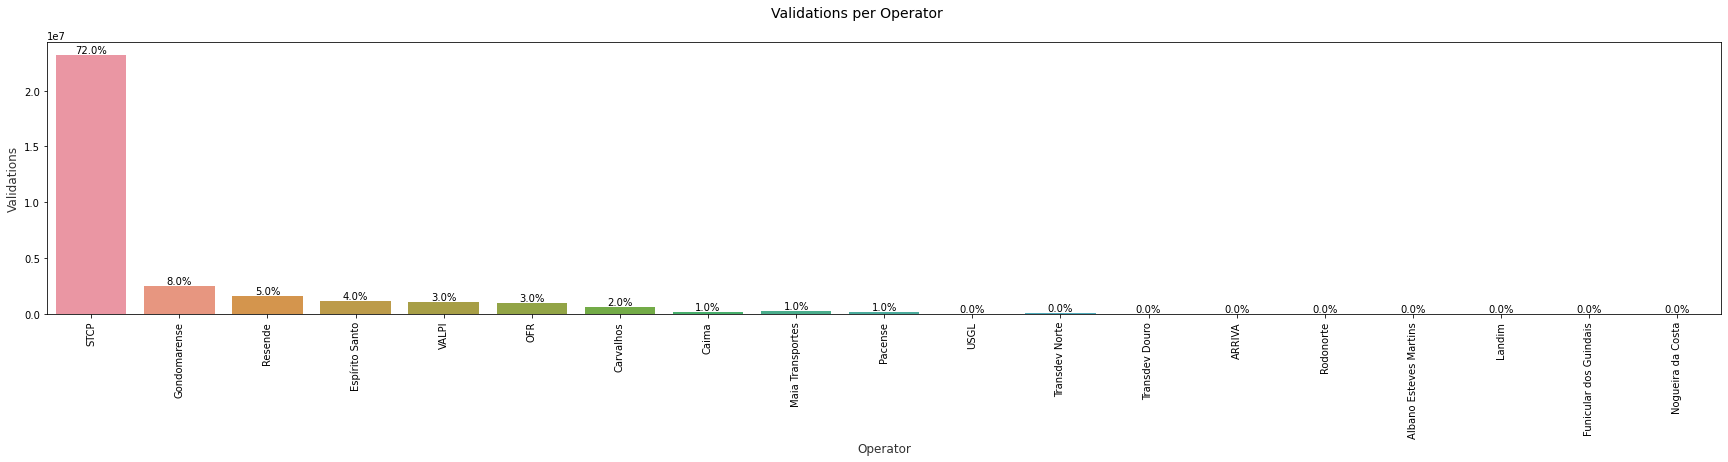

In [16]:
f, ax1 = plt.subplots(1, 1, figsize=(30, 5))
f.suptitle(f'Validations per Operator', fontsize=14)

ax1 = sns.barplot(x='operator', y='validations', data=df_operator) 
ax1.set_xlabel('Operator',size = 12,alpha=0.8)
ax1.set_ylabel('Validations',size = 12,alpha=0.8)

plt.xticks(rotation=90)

for rect, label in zip(ax1.patches, df_operator['%']):
    label = str(label) + '%'
    height = rect.get_height()
    ax1.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

plt.show()

As we can see in the plot above, the **STCP** has the largest share of the flow of people. So we are going to work only with the **STCP** operator.

In [17]:
df_stcp = df_bus[df_bus['operator'] == 'STCP']

#### Line Frequency

Let's analyze the frequency of each STCP bus line. The function below will create a geodataframe with the frequency for each combination of line, time of day and direction.

In [46]:
cutoffs = [0,6,18,22,24]
routes, stops, stop_times, trips, shapes = gtfs.import_gtfs("gtfs_bus.zip")
line_freq = gtfs.lines_freq(stop_times, trips, shapes, routes, cutoffs = cutoffs)

Let's vizualize the frequency of each line during the day (6 AM until 6PM)

In [49]:
# Line frequencies
condition_dir = line_freq.dir_id == 'Inbound'
condition_window = line_freq.window == '6:00-18:00'

gdf = line_freq.loc[(condition_dir & condition_window),:].reset_index()

gtfs.map_gdf(gdf = line_freq, 
              variable = 'ntrips', 
              colors = ["#d13870", "#e895b3" ,'#55d992', '#3ab071', '#0e8955','#066a40'], 
              tooltip_var = ['route_name', 'ntrips'] , 
              tooltip_labels = ['Route: ', 'Nº Trips: '], 
              breaks = [ 10, 20, 35, 50, 60, 80])


##### Missing Data

In [18]:
df_stcp.isna().sum()

year              0
month             0
day               0
hour              0
operator          0
public_line       8
direction        24
stop           2569
zone             29
validations       0
date              0
dtype: int64

In [19]:
missing_data = df_stcp[df_stcp['stop'].isnull()]
missing_percentage = (len(missing_data) / len(df_stcp)) * 100
print(f'Missing data percentage: {missing_percentage}%')

Missing data percentage: 0.04720446312778353%


The missing data percentage is very low, so we will drop the null values.

In [20]:
df_stcp.dropna(inplace=True)

#### Cleaning Wrong Data

There are some columns that contains some wrong data, let's filter these.

In [21]:
wrong_public_lines = ['_x000C_00', 'ÿÿÿÿ', 'p{°', '_x000C_', '_x0010__x0010__x0010__x0010_', '_x0014_@_x000F_',
      'ÿü_x0014_@', ':_x0010__x0011_Q', '_x0008_', 'ü_x0014_@_x000C_', 'P_x0018__x0010__x0018_', 
      'ÄÄ4', '_x0005__x0004_T@', '‚\x90_x0002_‚', 'D ID', '_x0014_@_x000C_', 'ÿÿü_x0014_', '?0>',
      '_x0002_„_x0014_@', '_x0004_', '804_x0003_', 'DgDa', 'ÿÿÿü'
]

In [22]:
df_stcp = df_stcp[~df_stcp['public_line'].isin(wrong_public_lines)]

In [23]:
df_stcp = df_stcp[~df_stcp['stop'].isin(['.'])]

#### Outliers

In [24]:
df_stcp_per_day_and_zone = df_stcp.groupby(['month', 'day', 'zone']).aggregate({ 'validations': sum }).reset_index()
df_stcp_per_day_and_zone = df_stcp_per_day_and_zone.sort_values('validations', ascending=False)


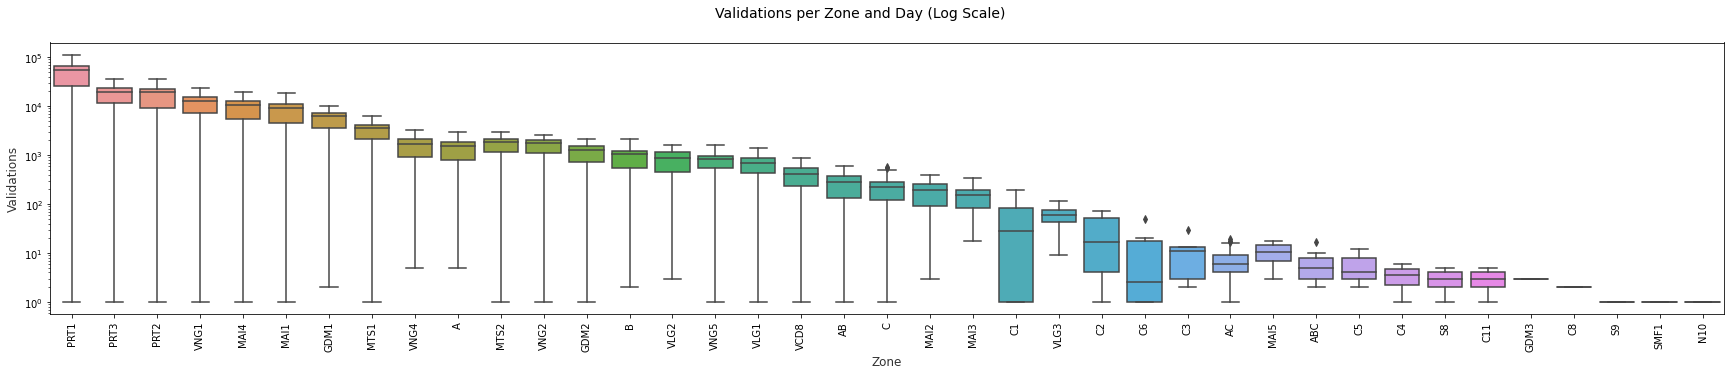

In [25]:
f, ax1 = plt.subplots(1, 1, figsize=(30, 5))
f.suptitle(f'Validations per Zone and Day (Log Scale)', fontsize=14)

sns.boxplot(x='zone', y='validations', data=df_stcp_per_day_and_zone, ax=ax1)
ax1.set_xlabel('Zone',size = 12,alpha=0.8)
ax1.set_ylabel('Validations',size = 12,alpha=0.8)
ax1.set_yscale('log')

plt.xticks(rotation=90)
plt.show()

There are not many outliers. So we are not going to treat these outliers.

##### Zones with the highest flow of people

In [26]:
df_validations_per_zone = df_stcp.groupby(['zone']).aggregate({ 'validations': sum }).reset_index()
df_validations_per_zone = df_validations_per_zone.sort_values(['validations'], ascending=[False])  # validations descending order 
df_validations_per_zone['validations(%)'] = df_validations_per_zone['validations'].apply(lambda x: x / df_validations_per_zone['validations'].sum() * 100).round(2)

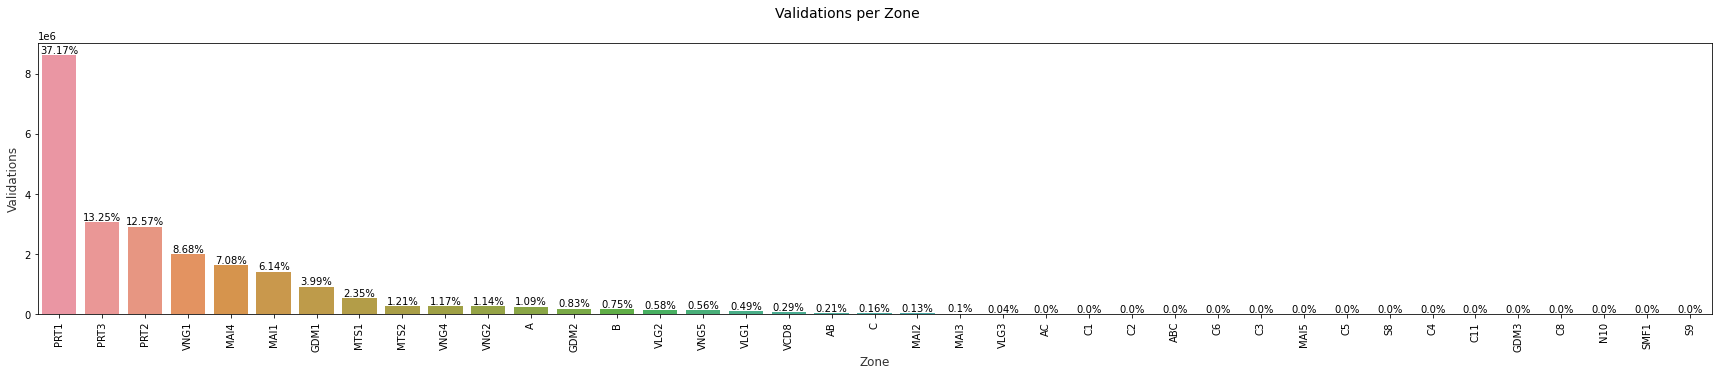

In [27]:
f, ax1 = plt.subplots(1, 1, figsize=(30, 5))
f.suptitle(f'Validations per Zone', fontsize=14)

ax1 = sns.barplot(x='zone', y='validations', data=df_validations_per_zone) 
ax1.set_xlabel('Zone',size = 12,alpha=0.8)
ax1.set_ylabel('Validations',size = 12,alpha=0.8)

plt.xticks(rotation=90)

for rect, label in zip(ax1.patches, df_validations_per_zone['validations(%)']):
    label = str(label) + '%'
    height = rect.get_height()
    ax1.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

plt.show()


Most routes do not have a significant flow.

As we can see in the barplots above, more than 60% of the flow of people is concentrated in the following zones:
- PRT1
- PRT2
- PRT3
- VNG1

##### Bus Lines with the highest flow of people

In [28]:
df_validations_per_line = df_stcp.groupby(['public_line']).aggregate({ 'validations': sum }).reset_index()  # agg validations by line
df_validations_per_line = df_validations_per_line.sort_values(['validations'], ascending=[False])  # validations descending order 
df_validations_per_line['validations(%)'] = df_validations_per_line['validations'].apply(lambda x: x / df_validations_per_line['validations'].sum() * 100).round(2)
df_validations_per_line = df_validations_per_line[df_validations_per_line['validations(%)'] > 1] # remove rows that percentage is below one

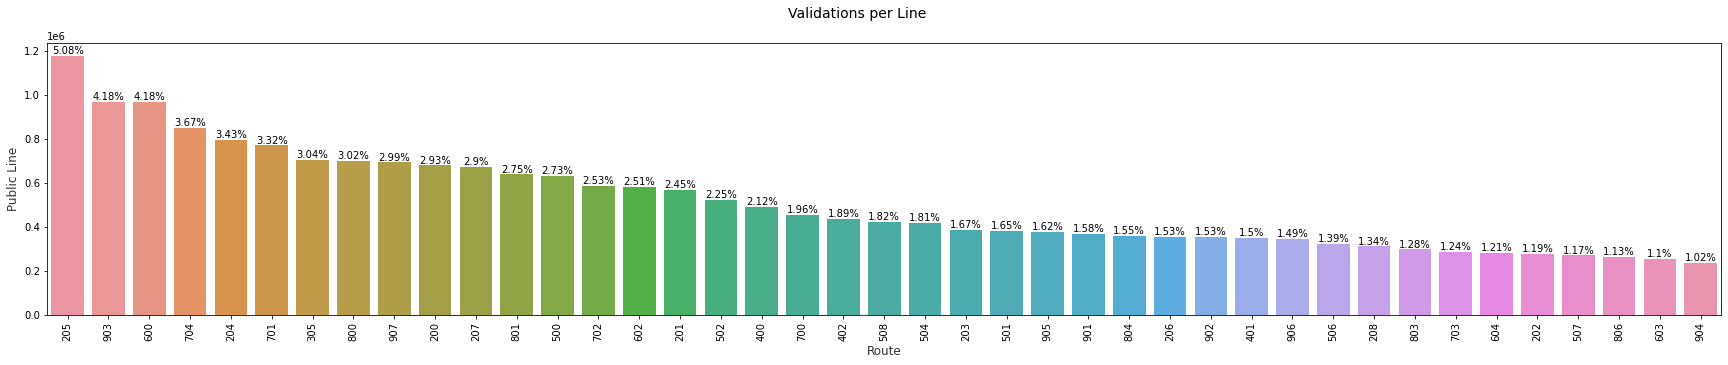

In [29]:
f, ax1 = plt.subplots(1, 1, figsize=(30, 5))
f.suptitle(f'Validations per Line', fontsize=14)

ax1 = sns.barplot(x='public_line', y='validations', data=df_validations_per_line) 
ax1.set_xlabel('Route',size = 12,alpha=0.8)
ax1.set_ylabel('Public Line',size = 12,alpha=0.8)

for rect, label in zip(ax1.patches, df_validations_per_line['validations(%)']):
    label = str(label) + '%'
    height = rect.get_height()
    ax1.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

plt.xticks(rotation=90)
plt.show()

In [137]:
dataset_val = pd.read_csv('dados_paragem.csv')
stops = pd.read_csv('stops_data.csv')

with open('fix_names.pkl', 'rb') as f:
    fix_names = pickle.load(f)
    dataset_val['Paragem'] = dataset_val['Paragem'].replace(fix_names)
    dataset_val['merge'] = dataset_val['Paragem'].apply(strip_accents)
    dataset_val = dataset_val.groupby('merge')['validations'].sum().reset_index()
    stops['merge'] = stops['stop_name'].apply(strip_accents)
    data = stops.merge(dataset_val, how='inner', on='merge')
    data['geometry'] = data['geometry'].apply(wkt.loads)
    crs = {'init': 'epsg:4326'}
    stops_df = gpd.GeoDataFrame(data, geometry=data.geometry, crs=crs)
    map_stops = stops_df.hvplot(c ='validations', title='Bus-Stop Flow', geo=True,  tiles='OSM', hover_cols=["stop_name", 'stop_code'],  alpha=0.5, width=700, height=700)

In [138]:
html = renderer.html(map_stops)
display_html(html, raw=True)

<!DOCTYPE html>
 
 
 
 
 
 Bokeh Application

#### Time Series Analysis

##### Lines

As we have many lines, we will take the main lines to observe the patterns in the time series.

In [30]:
df_ts = df_stcp.drop(columns=['year', 'month', 'day', 'hour'])
df_ts = df_ts.sort_values('date')
df_ts.index = df_ts['date']
df_ts.drop('date', axis=1, inplace=True)

In [31]:
main_lines = ['205',
              '903',
              '600',
              '704',
              '204',
              '701',
              '305',
              '800',
              '907',
              '200',
              '207',
              '801']

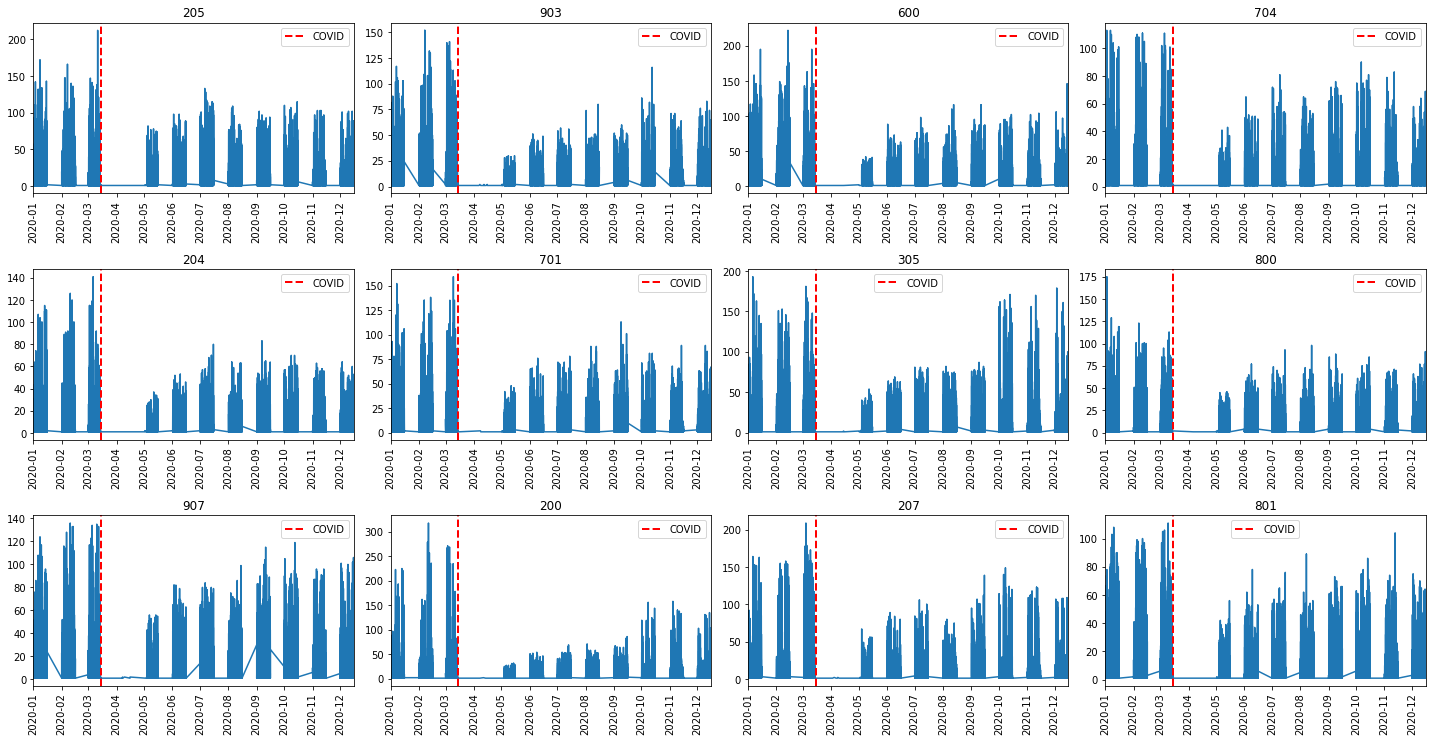

In [32]:
skip_plots = []
fig = plt.figure(figsize=(20,20))
for i, lt in enumerate(main_lines):
    tmp = df_ts[df_ts['public_line'] == lt]['validations']
    ax = fig.add_subplot(6, 4, i+1)
    plt.plot(tmp.index, tmp.values)
    plt.axvline(pd.to_datetime('2020-03-15'), color='r', linestyle='--', lw=2, label='COVID')
    plt.legend()
    plt.xticks(rotation=90)
    ax.set_title(lt)
    ax.set_xlim(df_ts.index.min(), df_ts.index.max())

fig.tight_layout()

**Observations:**

- On all routes, there seems to be a pattern where at the end of the month or beginning of the month there is always a significant decrease in flow.

##### COVID-19 Analysis

On all routes without exception, it is possible to observe that there was a drop in the flow at the beginning of covid (from middle of March onwards). At the beginning of May, the flow began to increase discreetly, but until the end of 2020 it did not return to the same volume as before the covid, maybe because many people started working remotely.

Let's improve our dataset and add the day name and if it's holiday or not.

In [33]:
df_ts_improved = df_ts.copy()
df_ts_improved['weekday'] = df_ts.index.day_name()  # add day name

In [34]:
# add holiday
pt = holidays.PortugalExt()
df_ts_improved['holiday'] = pd.Series(df_ts_improved.index).apply(lambda x: pt.get(x)).values
df_ts_improved['holiday'] = df_ts_improved['holiday'].astype('bool').astype('int')

Let's go a little deeper and see the patterns over the course of a week.

In [127]:
df_week = df_ts_improved[df_ts_improved['public_line'].isin(main_lines)]
df_week = df_week.groupby([df_week.index.weekday.rename('wkday'),df_week.index.hour.rename('hour')]).mean()
df_week.drop(columns=['holiday'], inplace=True)

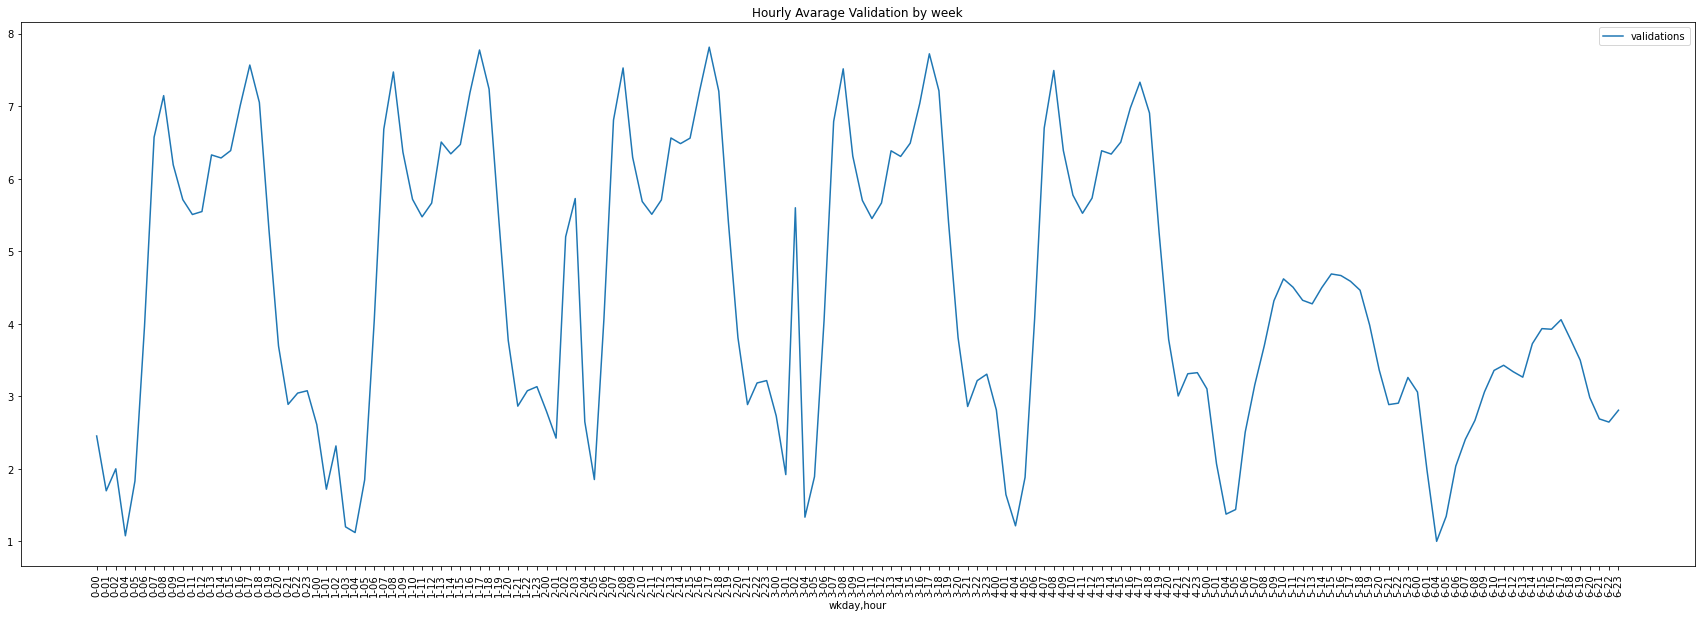

In [132]:
ax = df_week.plot(figsize=(30,10));
ax.set_title('Hourly Avarage Validation by week');
ax.set_xticks(range(len(df_week)));
#plt.axvline((df_week.index.get_level_values(0) == 24).any(), color='r', linestyle='--', lw=2, label='COVID')
ax.set_xticklabels(["%s-%02d" % item for item in df_week.index.tolist()], rotation=90);


According to the chart above, there is a large flow during the working days (first five peaks) and it decreases on weekends (last two peaks).

In addition, we can notice a pattern of peaks during the working days.

Now, we can separate the working days and the weekends or holidays.

In [37]:
df_working_day = df_ts_improved[
    (df_ts_improved['weekday'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']))
    & 
    (df_ts_improved['holiday'] == 0)
]

In [38]:
df_weekend = df_ts_improved[
    (df_ts_improved['weekday'].isin(['Saturday', 'Sunday']))
]

In [39]:
df_holiday = df_ts_improved[
    (df_ts_improved['holiday'] == 1)
]

Going deeper, let's see a daily analysis. First, in a working day.

In [40]:
df_working_day = df_working_day[df_working_day['public_line'].isin(main_lines)]
df_working_day = df_working_day.groupby([df_working_day.index.hour.rename('hour')]).mean()
df_working_day.drop(columns=['holiday'], inplace=True)

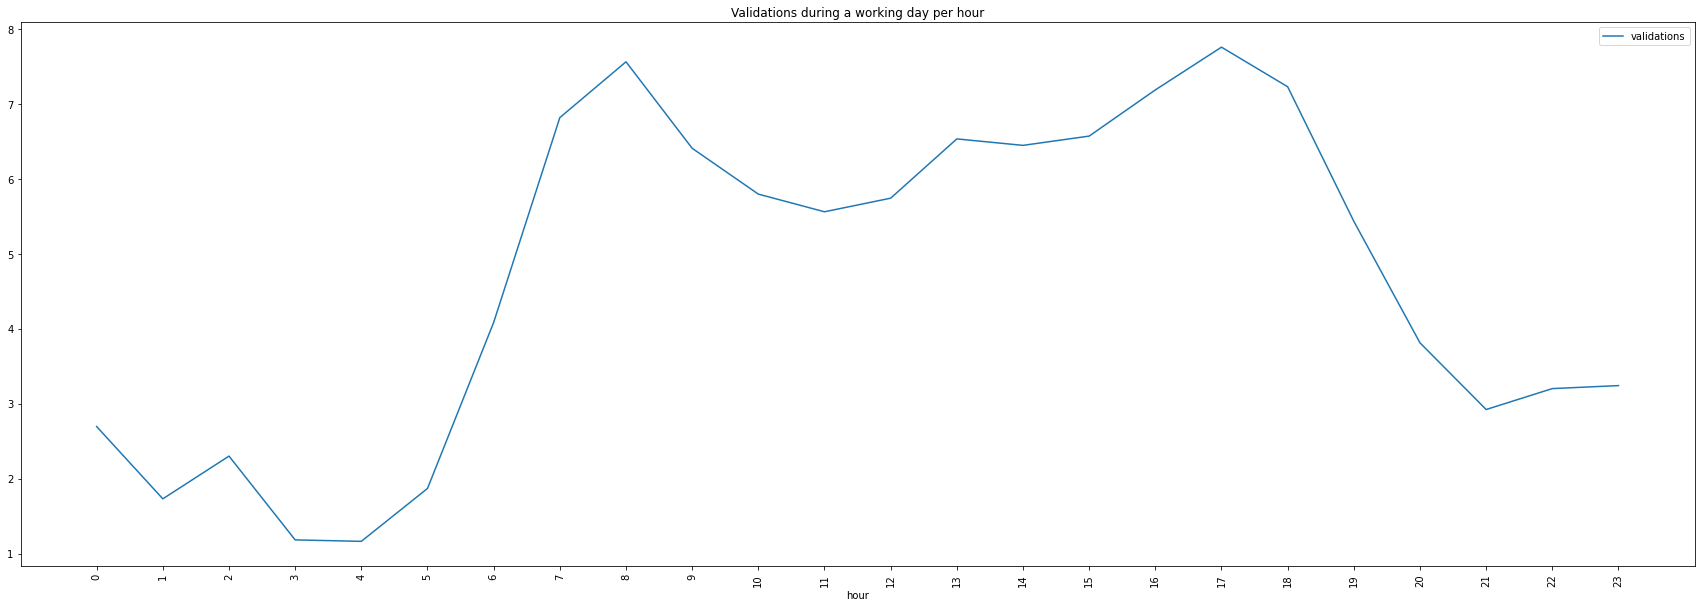

In [41]:
ax = df_working_day.plot(figsize=(30,10));
ax.set_title('Validations during a working day per hour');
ax.set_xticks(range(len(df_working_day)));
ax.set_xticklabels([item for item in df_working_day.index.tolist()], rotation=90);

- On a working day it is possible to notice that the flow starts at 6am and reaches a peak near 8am (going to work?);
- On many of the routes there is also a peak flow between 1pm and 2pm (lunch break?);
- The last peak happens around 18:00 (end of work?);

Now, let's make a Daily analysis on a weekend

In [42]:
df_weekend = df_weekend[df_weekend['public_line'].isin(main_lines)]
df_weekend = df_weekend.groupby([df_weekend.index.hour.rename('hour')]).mean()
df_weekend.drop(columns=['holiday'], inplace=True)

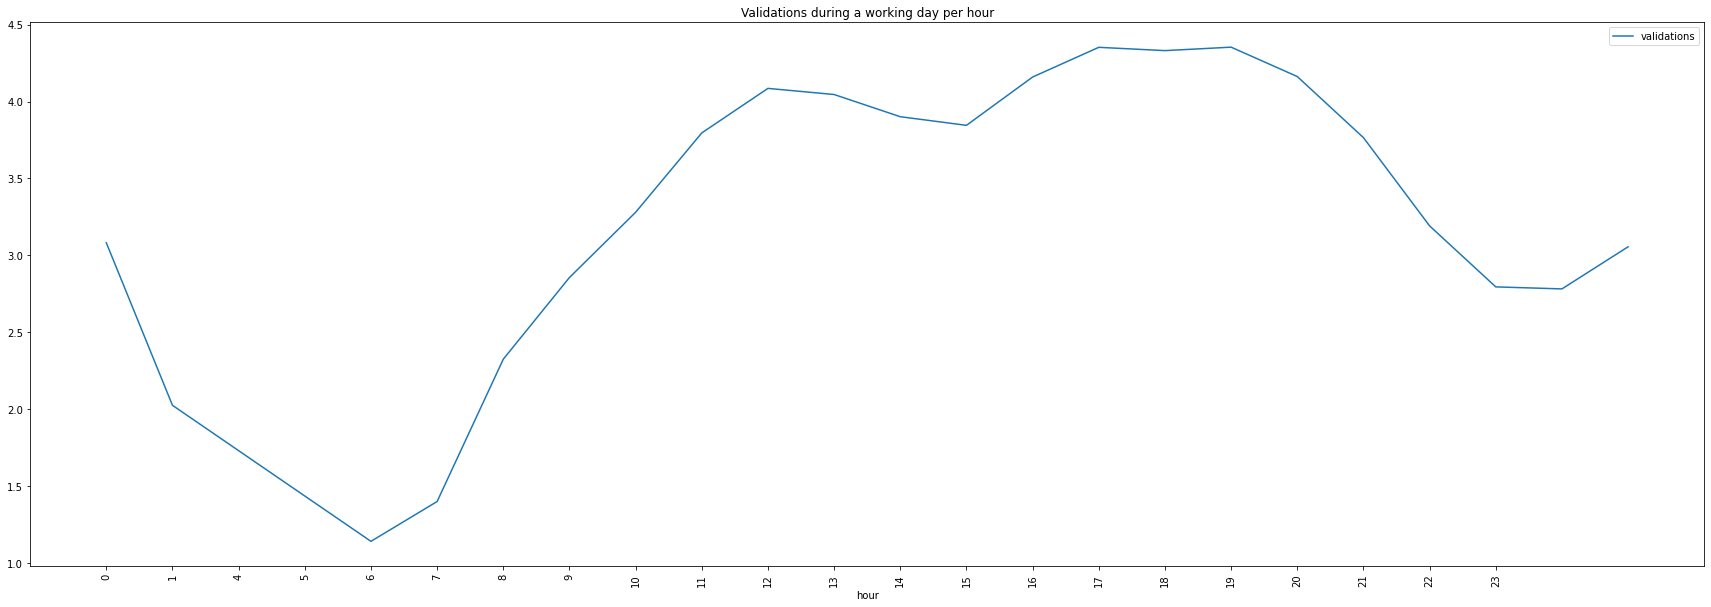

In [43]:
ax = df_weekend.plot(figsize=(30,10));
ax.set_title('Validations during a working day per hour');
ax.set_xticks(range(len(df_weekend)));
ax.set_xticklabels([item for item in df_weekend.index.tolist()], rotation=90);

- On weekends, the flow also starts at 6 am, but the peak takes place a little later, between 12am;
- The flow is lower compared to weekdays, but in general it remains more constant during the daytime hours;

Lastly, let's make a Daily analysis on a holiday.

In [44]:
df_holiday = df_holiday[df_holiday['public_line'].isin(main_lines)]
df_holiday = df_holiday.groupby([df_holiday.index.hour.rename('hour')]).mean()
df_holiday.drop(columns=['holiday'], inplace=True)

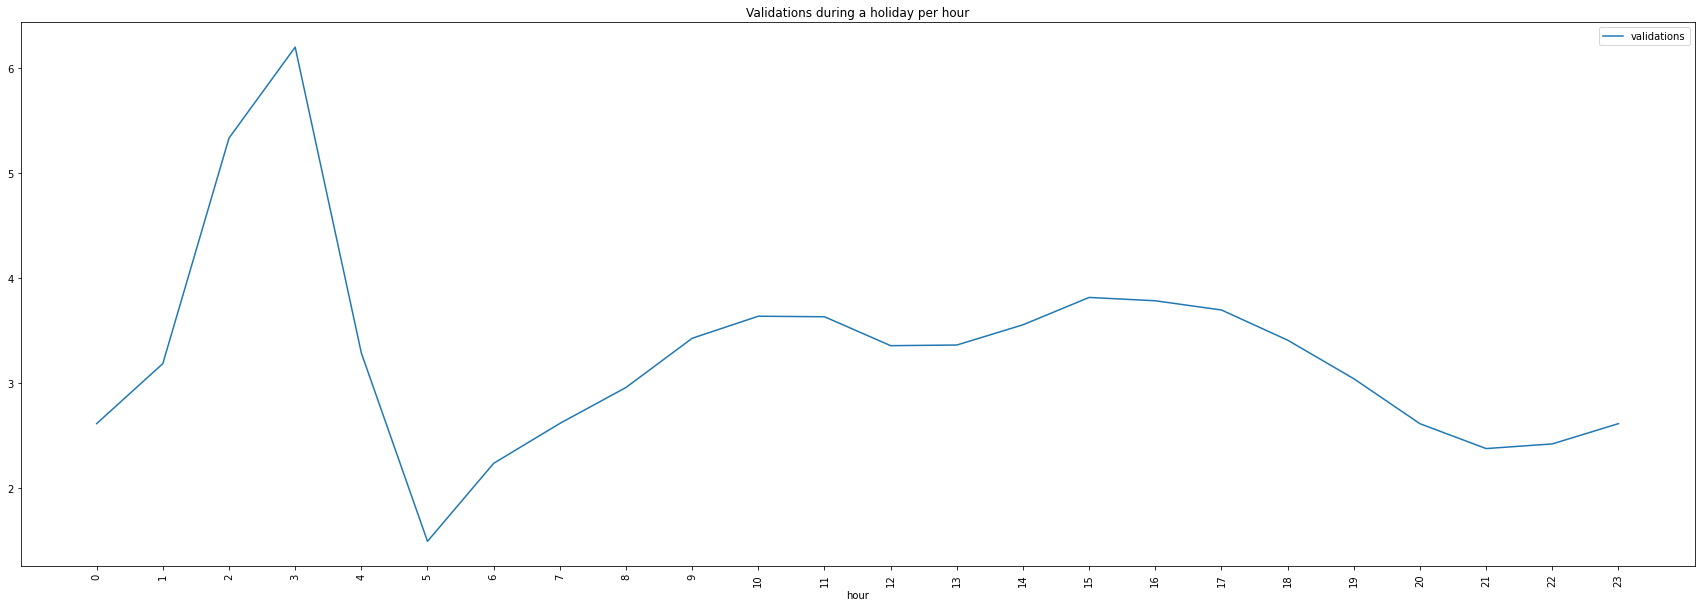

In [45]:
ax = df_holiday.plot(figsize=(30,10));
ax.set_title('Validations during a holiday per hour');
ax.set_xticks(range(len(df_holiday)));
ax.set_xticklabels([item for item in df_holiday.index.tolist()], rotation=90);

- On holidays, there is a peak at 3am. Maybe there is an outlier that caused this behavior;
- During the daytime hours, the flow is more constant;

##  3 - <span style="color:blue">Forecasting Model</span>  <a class="anchor" id="third-bullet"></a>

#### Forecasting the inbound flow of people

Let's converting hourly dataset into daily dataset, categorical columns into labels, and fix gaps of date.

In [84]:
forecast_dataset = pd.read_csv('data/out.csv', parse_dates=['date']).drop(columns=['year', 'month', 'day', 'hour'])
forecast_dataset = forecast_dataset[forecast_dataset['operator'] == 'STCP']
forecast_dataset['group_entry_zone'] = forecast_dataset['entry_zone'].astype(str).str[:2]
forecast_dataset['group_exit_zone'] = forecast_dataset['exit_zone'].astype(str).str[:2]
forecast_dataset, dic = label_gen(forecast_dataset, ['group_entry_zone', 'group_exit_zone', 'entry_zone', 'exit_zone'])
forecast_dataset['validations'] = forecast_dataset['validations'].astype(np.uint16)
cols_int8 = [ 'entry_zone','exit_zone', 'group_entry_zone', 'group_exit_zone']

for i in cols_int8:
    forecast_dataset[i] = forecast_dataset[i].astype(np.uint8) #.astype('category') #.astype(np.uint8)

In [85]:
forecast_dataset = fix_cells(forecast_dataset, ['entry_zone', 'exit_zone', 'group_entry_zone', 'group_exit_zone'], 
               forecast_dataset['date'].min(), 
               forecast_dataset['date'].max(),
               ffill = False,
               irregular_shape_before=False,
               irregular_shape_after=False,
               )
forecast_dataset['validations'] = forecast_dataset['validations'].fillna(0).astype(np.uint16)
forecast_dataset = forecast_dataset.reset_index()

Let's split the dataset in order train and test the model

In [86]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [87]:
save_dataset(forecast_dataset, file='./train/train.json', train=True)
save_dataset(forecast_dataset, file='./test/test.json', train=False)

In [121]:
train_ds = FileDataset('./train/', freq="H")
test_ds = FileDataset('./test/', freq="H")

#### Creating a simple Seasonal Naive model


Let's create a Seasonal Naive model, that will be important to benchmark with a more complex model, and compare the results.

In [100]:
predictor_naive = SeasonalNaivePredictor(
    freq='H',
    prediction_length=24 * 7,
    season_length=24 * 7,
)

In [98]:
forecasts = list(predictor_naive.predict(train_ds))

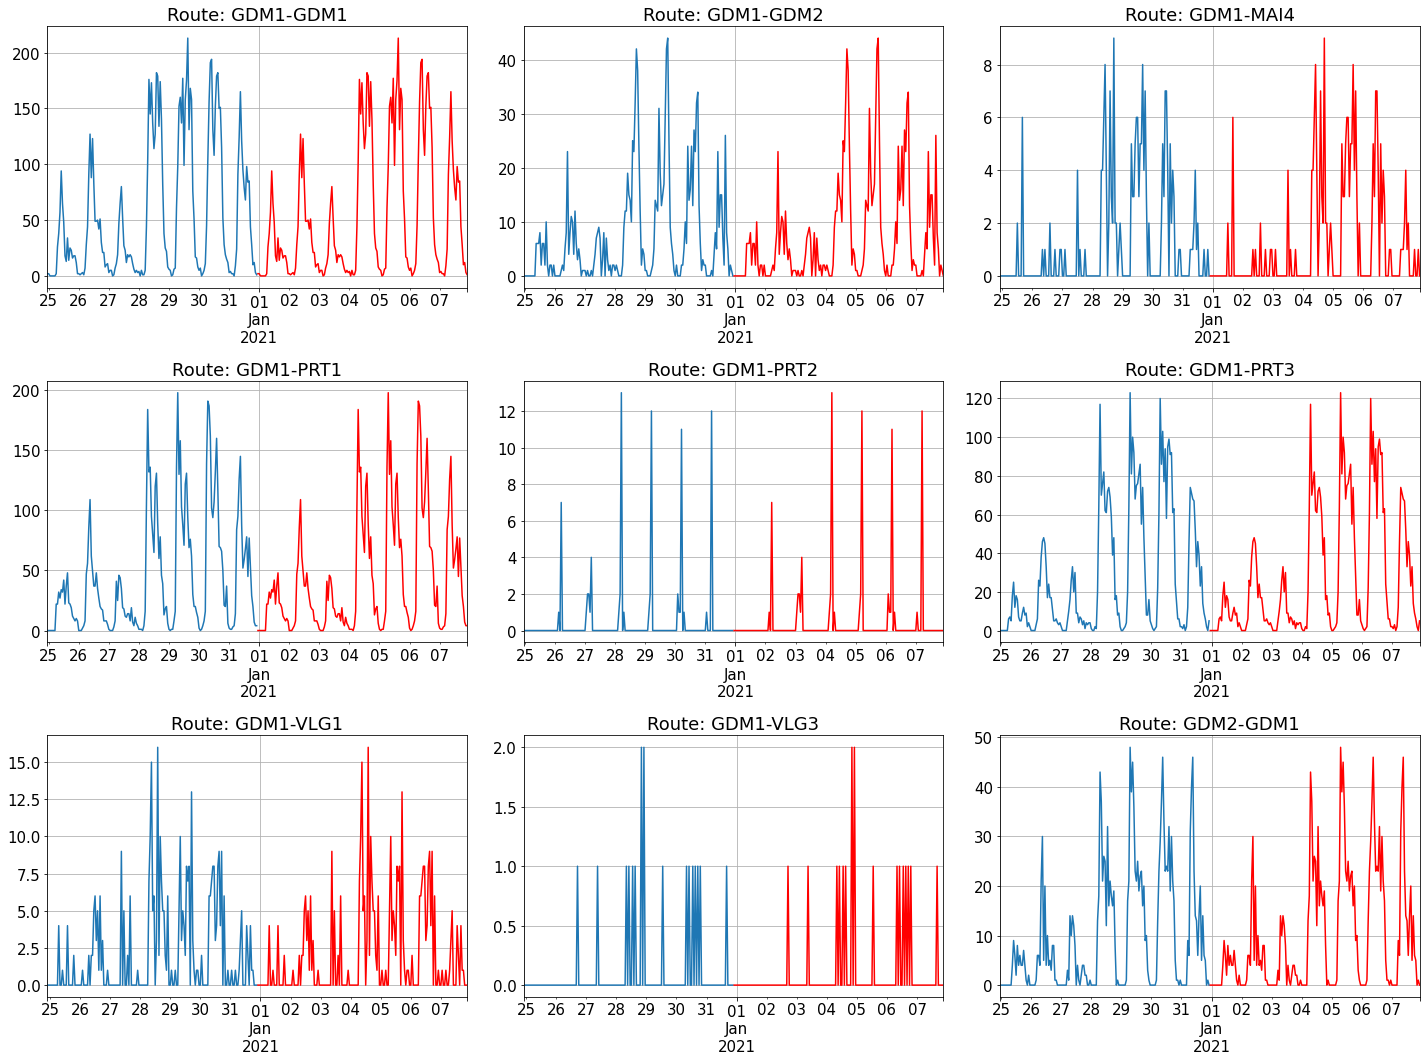

In [122]:
plt.figure(figsize=(20, 15))

for idx, (entry, f) in islice(enumerate(zip(train_ds, forecasts)), 9):
    ax = plt.subplot(3, 3, idx+1)
    to_pandas(entry)[-24 * 7:].plot()
    f.plot(color="r")
    plt.grid()
    plt.title(f"Route: {f.item_id}")

plt.gcf().tight_layout()
plt.show()

#### Creating a more complex model: DeepAR

DeepAR is a probabilistic forecast model based on training an autoregressive recurrent neural network model on a large number of related time series.

In [106]:
prediction_length= 24 * 7

deepar_estimator = DeepAREstimator(
    freq='H',
    trainer_kwargs=dict(max_epochs=3),
    prediction_length=prediction_length,
    distr_output=NegativeBinomialOutput(),
    num_feat_static_cat=4,
    cardinality=[107, 110, 15, 15],
)

In [107]:
deepar_predictor = deepar_estimator.train(train_ds, cache_data=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                  | Params
------------------------------------------------
0 | model | DeepARModel           | 57.1 K
1 | loss  | NegativeLogLikelihood | 0     
------------------------------------------------
57.1 K    Trainable params
0         Non-trainable params
57.1 K    Total params
0.228     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 4.01330 (best 4.01330), saving model to '/workspace/lightning_logs/version_9/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 2.85454 (best 2.85454), saving model to '/workspace/lightning_logs/version_9/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 2.47427 (best 2.47427), saving model to '/workspace/lightning_logs/version_9/checkpoints/epoch=2-step=150.ckpt' as top 1


In [112]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=deepar_predictor,
)

print("Obtaining time series conditioning values ...")
tss_deepar = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts_deepar = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...


  0%|          | 0/142 [00:00<?, ?it/s]

Obtaining time series predictions ...


  0%|          | 0/142 [00:00<?, ?it/s]

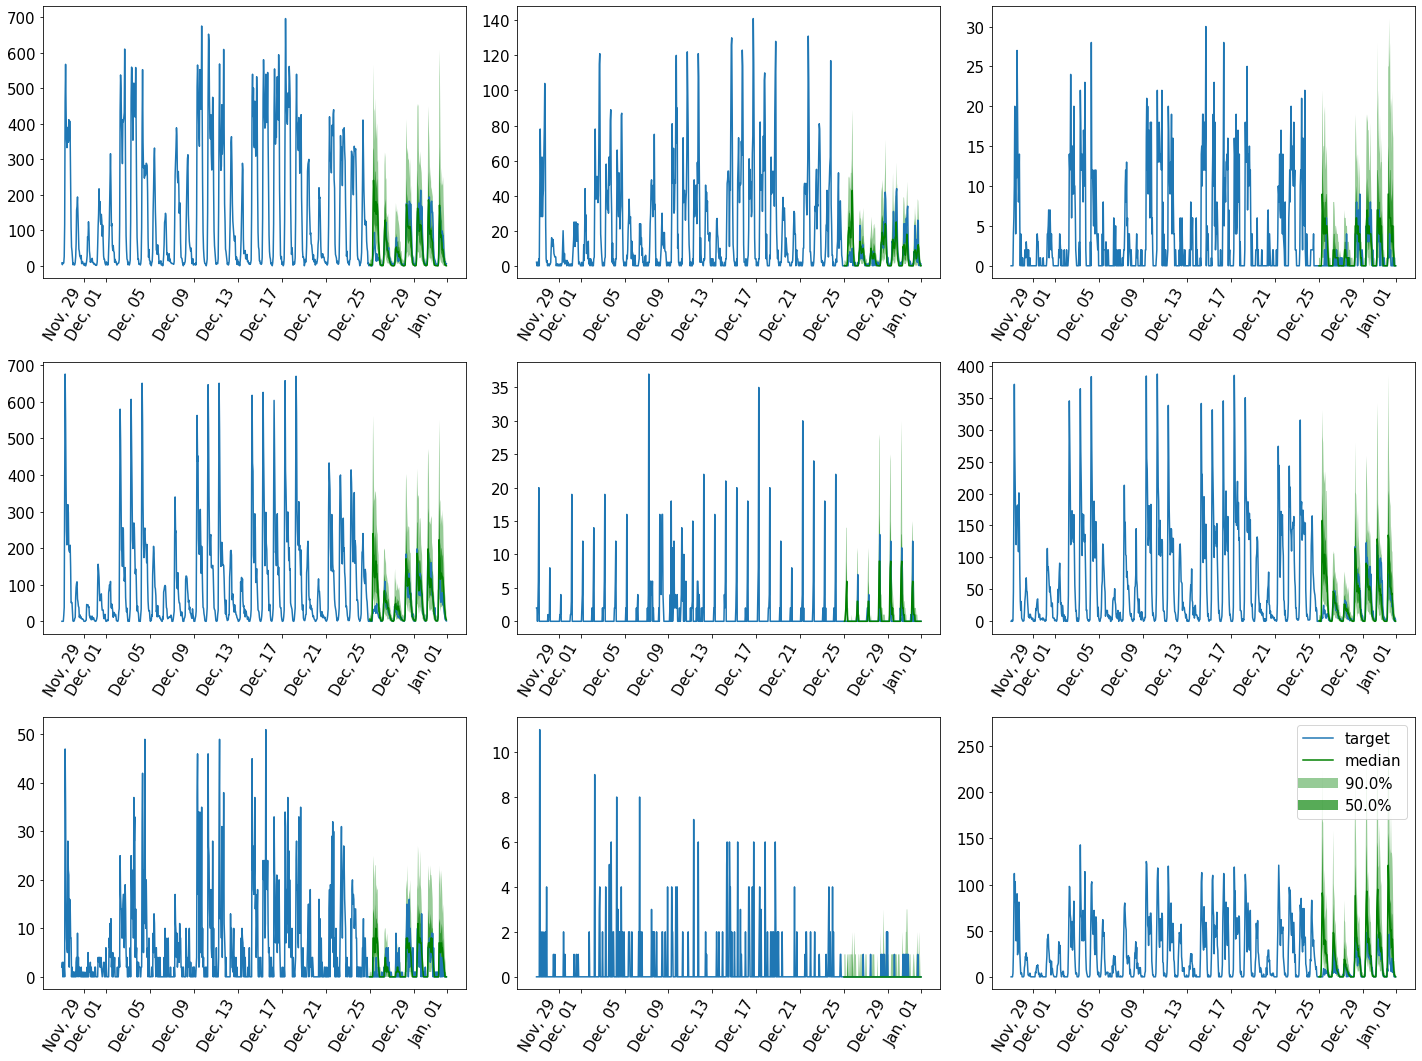

In [115]:
plt.figure(figsize=(20, 15))
date_formatter = matplotlib.dates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_deepar, tss_deepar)), 9):
    ax = plt.subplot(3, 3, idx+1)
    
    plt.plot(ts[-5 * prediction_length:], label="target")
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formatter)
    
plt.gcf().tight_layout()
plt.legend()
plt.show()

In [117]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
aggregate_metrics_naive, entrywise_metrics_naive = backtest_metrics(test_ds, predictor_naive, evaluator=evaluator)
aggregate_metrics_deepar, entrywise_metrics_deepar = evaluator(tss_deepar, forecasts_deepar)


100%|██████████| 142/142 [00:00<00:00, 720.44it/s]

Running evaluation: 100%|██████████| 142/142 [00:00<00:00, 331.66it/s]

Running evaluation: 142it [00:00, 1068.21it/s]


DeepAR seems to have a better score compared to the base model. 

In [118]:
pd.DataFrame.from_records(
    [aggregate_metrics_naive, aggregate_metrics_deepar],
    index=["Naive seasonal", "DeepAR"]
).transpose()

Naive seasonal         DeepAR
MSE                           3.053874e+04   12242.600459
abs_error                     8.721580e+05  409687.000000
abs_target_sum                5.622150e+05  562215.000000
abs_target_mean               2.356703e+01      23.567027
seasonal_error                2.351467e+01      23.514668
MASE                          1.146594e+00       0.574984
MAPE                          2.165922e+00       1.228038
sMAPE                         1.203815e+00       1.117069
MSIS                          4.586377e+01       9.527581
QuantileLoss[0.1]             1.559955e+06  151738.600000
Coverage[0.1]                 5.365526e-01       0.078303
QuantileLoss[0.5]             8.721580e+05  409687.000000
Coverage[0.5]                 5.365526e-01       0.339956
QuantileLoss[0.9]             1.843612e+05  284731.000000
Coverage[0.9]                 5.365526e-01       0.694291
RMSE                          1.747534e+02     110.646285
NRMSE                         7.415164e+00       4.694962
ND                            1.551289e+00       0.728702
wQuantileLoss[0.1]            2.774659e+00       0.269894
wQuantileLoss[0.5]            1.551289e+00       0.728702
wQuantileLoss[0.9]            3.279194e-01       0.506445
mean_absolute_QuantileLoss    8.721580e+05  282052.200000
mean_wQuantileLoss            1.551289e+00       0.501680
MAE_Coverage                  2.788509e-01       0.129150
OWA                                    NaN            NaN

##  4 - <span style="color:blue">Conclusion</span>  <a class="anchor" id="fourth-bullet"></a>

We could verify that more than 70% of the flow of people on public transportation focuses on two operators - STCP (bus): 42.45% and Metro do Porto (subway): 35.1%. On all routes without exception, it is possible to observe that there was a drop in the flow at the beginning of covid (from the middle of March onwards). At the beginning of May, the flow began to increase discreetly, but until the end of 2020 it did not return to the same volume as before the covid, maybe because many people started working remotely. There was also a large flow during the working days and it decreases on weekends. It is also possible to see the peaks of flow near 8am and 6pm on weekdays, demonstrating the start and end times of work hours. On weekends, the flow also starts at 6am, but the peak takes place a little later, about 12am.
In order to decrease the peak of flows, we proposed a solution which offers incentives for commuters to travel in off-peak periods based on the flow of the forecast model output. These incentives include random (raffle-like) rewards, social influence and personalized offers.


## ⏭️ Appendix

#### Dataset TIP Z2Z pre-treatment

First, let's read the `TIP MOD Z2Z` (OD Validation data on public transport in Porto Metropolitan Area) from all months



In [ ]:
df_jan = pd.read_excel('./data/TIP/202001_20210113/202001_MOD_Z2Z.xlsx')
df_feb = pd.read_excel('./data/TIP/202002_20210113/202002_MOD_Z2Z.xlsx')
df_mar = pd.read_excel('./data/TIP/202003_20210113/202003_MOD_Z2Z.xlsx')
df_apr = pd.read_excel('./data/TIP/202004_20210114/202004_MOD_Z2Z.xlsx')
df_may = pd.read_excel('./data/TIP/202005_20210114/202005_MOD_Z2Z.xlsx')
df_jun = pd.read_excel('./data/TIP/202006_20210114/202006_MOD_Z2Z.xlsx')
df_jul = pd.read_excel('./data/TIP/202007_20210115/202007_MOD_Z2Z.xlsx')
df_aug = pd.read_excel('./data/TIP/202008_20210115/202008_MOD_Z2Z.xlsx')
df_sep = pd.read_excel('./data/TIP/202009_20201209/202009_MOD_Z2Z.xlsx')
df_oct = pd.read_excel('./data/TIP/202010_20210111/202010_MOD_Z2Z.xlsx')
df_nov = pd.read_excel('./data/TIP/202011_20210111/202011_MOD_Z2Z.xlsx')
df_dec = pd.read_excel('./data/TIP/202012_20210125/202012_MOD_Z2Z.xlsx')

In [ ]:
months = [
  df_jan,
  df_feb,
  df_mar,
  df_apr,
  df_may,
  df_jun,
  df_jul,
  df_aug,
  df_sep,
  df_oct,
  df_nov,
  df_dec
]

Now, to make things easier, we are going to concatenate all dataframes into one to get an overview of the data.

In [ ]:
df = pd.concat(months, ignore_index=True)

Let's rename the columns to English

In [ ]:
df = df.rename(columns={
  'Ano': 'year', 
  'Mês': 'month', 
  'Dia': 'day', 
  'Hora': 'hour', 
  'Operador': 'operator', 
  'ZonaEntrada': 'entry_zone', 
  'ZonaSaida': 'exit_zone', 
  'Validações': 'validations'
})

`year`, `month`, `day` and `hour` can be converted into one datetime column.

In [ ]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], format = '%Y/%M/%D %H')

The columns `entry_zone` and `exit_zone` have spaces in the values. Let's strip the strings to remove these spaces.

In [ ]:
df[['entry_zone', 'exit_zone']] = df[['entry_zone', 'exit_zone']].apply(lambda x: x.str.strip())

Write a new csv file with the treated data

In [ ]:
df.to_csv('data/treated_tip_z2z.csv', index=False)

#### Dataset TIP Bus pre-treatment

First, let's read the `TIP Validações Ferroviárias` (bus data) from all months.

In [ ]:
df_jan = pd.read_excel('./data/TIP/202001_20210113/202001_Validações Rodov.xlsx')
df_feb = pd.read_excel('./data/TIP/202002_20210113/202002_Validações Rodov.xlsx')
df_mar = pd.read_excel('./data/TIP/202003_20210113/202003_Validações Rodov.xlsx')
df_apr = pd.read_excel('./data/TIP/202004_20210114/202004_Validações Rodov.xlsx')
df_may = pd.read_excel('./data/TIP/202005_20210114/202005_Validações Rodov.xlsx')
df_jun = pd.read_excel('./data/TIP/202006_20210114/202006_Validações Rodov.xlsx')
df_jul = pd.read_excel('./data/TIP/202007_20210115/202007_Validações Rodov.xlsx')
df_aug = pd.read_excel('./data/TIP/202008_20210115/202008_Validações Rodov.xlsx')
df_sep = pd.read_excel('./data/TIP/202009_20201209/202009_Validações Rodov.xlsx')
df_oct = pd.read_excel('./data/TIP/202010_20210111/202010_Validações Rodov.xlsx')
df_nov = pd.read_excel('./data/TIP/202011_20210111/202011_Validações Rodov.xlsx')
df_dec = pd.read_excel('./data/TIP/202012_20210125/202012_Validações Rodov.xlsx')

In [ ]:
months = [
  df_jan,
  df_feb,
  df_mar,
  df_apr,
  df_may,
  df_jun,
  df_jul,
  df_aug,
  df_sep,
  df_oct,
  df_nov,
  df_dec
]

Let's concatenate all months.

In [ ]:
df = pd.concat(months, ignore_index=True)

Rename the columns to English

In [ ]:
df = df.rename(columns={
  'Ano': 'year', 
  'Mês': 'month', 
  'Dia': 'day', 
  'Hora': 'hour', 
  'Operador': 'operator', 
  'Linha_ao_Publico': 'public_line', 
  'Sentido': 'direction', 
  'Paragem': 'stop',
  'Zona': 'zone',
  'Validações': 'validations'
})

Create a new datetime column

In [ ]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], format = '%Y/%M/%D %H')

Strip the spaces in the `zone` column.

In [ ]:
df[['zone']] = df[['zone']].apply(lambda x: x.str.strip())

Write a new csv file with the treated data.

In [ ]:
df.to_csv('data/treated_tip_bus.csv', index=False)

#### Forecast dataset pre-build

In [ ]:
def label_gen(df, lista, new=False):
    '''
    Generate categorical Labels
    '''

    dic = {}

    for l in lista: 
        le = LabelEncoder()
        ids = le.fit_transform(df[l])
        df[f'_{l}' if new else f'{l}'] = ids
        dic[l] = dict(zip(le.classes_, range(len(le.classes_))))
        
    return df, dic

In [ ]:
def fix_cells(df, index_cols, min_date, end_date, ffill=False, ffill_col=None, irregular_shape_before=False, irregular_shape_after=False):
    
    product_date_columns = index_cols + ['date']

    # We will first save away the minimum date of for each product for later
    minimum_date_per_product = df[product_date_columns].groupby(index_cols).agg('min')
    minimum_date_per_product = minimum_date_per_product.rename({'date': 'minimum_date'}, axis=1)

    # Then save away the maximum date of for each product for later
    maximum_date_per_product = df[product_date_columns].groupby(index_cols).agg('max')
    maximum_date_per_product = maximum_date_per_product.rename({'date': 'maximum_date'}, axis=1)

    # Then you find all possible product/date combinations, as said above, this might lead 
    # to a huge dataframe (of size len(unique_products) times len(unique_dates)):
    all_dates = pd.DataFrame(index=pd.date_range(min_date, end_date, freq='H')).reset_index()
    all_dates = all_dates.rename({'index': 'date'}, axis=1)
    all_products = df[index_cols].drop_duplicates()
    all_dates['key'] = 0
    all_products['key'] = 0
    all_product_date_combinations = pd.merge(all_dates, all_products, on='key').drop('key', axis=1)

    # You then create all possible selling dates for your products
    df = df.set_index(product_date_columns)
    all_product_date_combinations = all_product_date_combinations.set_index(product_date_columns)
    df = df.join(all_product_date_combinations, how='right')

    if irregular_shape_before:
        # Now you only have to drop all rows that are before the first starting date of a product
        df = df.join(minimum_date_per_product).reset_index()
        df = df[df['date'] >= df['minimum_date']]
        df = df.drop(columns=['minimum_date'], axis=1)
    
    if irregular_shape_after:
        # Now you only have to drop all rows that are before the first starting date of a product
        df = df.set_index(index_cols)
        df = df.join(maximum_date_per_product).reset_index()
        df = df[df['date'] <= df['maximum_date']]
        df = df.drop(columns=['maximum_date'], axis=1)

    if ffill:
        df[ffill_col] = df.groupby(index_cols)[ffill_col].ffill().bfill()
    
    return df

In [ ]:
def save_dataset(df, file, train=True):
    prediction_length = 24 * 7

    with open(f'{file}', 'wb') as b:  
        if train:
            df = df.iloc[:-prediction_length]
        lista = ['entry_zone','exit_zone', 'group_entry_zone', 'group_exit_zone']
        for i, f in df.groupby(lista):
            x = {        
                    FieldName.TARGET: f['validations'].dropna().tolist(),
                    FieldName.START: str(f['date'].min()),
                    FieldName.FEAT_STATIC_CAT: [i[0], i[1], i[2], i[3]],
                    FieldName.ITEM_ID: '-'.join([list(dic[lista[n]].keys())[list(dic[lista[n]].values()).index(i[n])] for n in range(2)])

                }
            b.write(json.dumps(x, ensure_ascii=False, ignore_nan=True, cls=NumpyEncoder).encode("utf-8"))
            b.write('\n'.encode("utf-8"))

#### GTFS Treatment

In [131]:
def strip_accents(text):
    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass

    text = unicodedata.normalize('NFD', text)\
        .encode('ascii', 'ignore')\
        .decode('utf-8')
    return ''.join(filter(str.isalnum, str(text).lower()))

##  5 - <span style="color:blue">References</span>  <a class="anchor" id="fifth-bullet"></a>

¹. https://www.tomtom.com/en_gb/traffic-index/ranking/?country=PT

². https://www.deco.proteste.pt/familia-consumo/orcamento-familiar/noticias/transportes-publicos-ineficazes-em-6-cidades

